In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
plt.style.use('dark_background') 

def highlight_odd_rows(s):
    '''
    Changes style of a dataframe visualization
    Args:
       s : The row of the dataframe
    Returns:
    '''
    styles = []
    for i in range(len(s)):
        if i % 2 == 1:
            styles.append('background-color: indigo; border: 1px solid white;')
        else:
            styles.append('border: 1px solid white;')
    return styles

In [3]:
df = pd.read_csv("regularizacion100000.csv", encoding = 'utf-8')

In [4]:
df.head().style.apply(highlight_odd_rows)

,VIN,_id,host,ip,apiKey,userId,idReporte,requestParameters,requestUrl,responseCode,responseCodeStatus,requestTime,responseTime,labels,idRespuesta,idConsulta,responseBody,carfaxUsaData,alertas,firewallUsa
0,1GCWGGBA0D1111037,673f678e12327586f2ae7414,10.240.2.38:80,"201.116.128.213:8772,10.240.8.27, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,nan,nan,{},/v2/regularizacion/1GCWGGBA0D1111037,200,ok,2024-11-21 11:02:06,2024-11-21 11:02:06,nan,673f678e12327586f2ae7415,673f678e12327586f2ae7414,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""marca"":""CHEVROLET"",""modelo"":""EXPRESS 2500"",""anioModelo"":""2013"",""fabricante"":""GENERAL MOTORS LLC"",""paisOrigen"":""ESTADOS UNIDOS (USA)"",""tiempoConsulta"":""2024-11-21T11:02:06-06:00"",""tiempoRespuesta"":""2024-11-21T11:02:06-06:00""}","{""vin"":""1GCWGGBA0D1111037"",""timestamp"":""2024-11-21T11:01:44.000"",""components"":{""potentialFraudFile"":{""year"":2013,""make"":""CHEVROLET"",""model"":""EXPRESS 2500"",""rateEvasionFlags"":[],""potentialFraudFlags"":[],""vinCloningFlags"":[]}},""customCalculationOdometer"":""""}",[],1
1,1GCWGGBAOD1111037,673f678a74141818244e5119,10.240.2.38:80,"201.116.128.213:8772,10.240.8.27, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,nan,nan,{},/v2/regularizacion/1GCWGGBAOD1111037,200,ok,2024-11-21 11:02:02,2024-11-21 11:02:03,nan,673f678b74141818244e511a,673f678a74141818244e5119,"{""mensajes"":[{""codigo"":4,""mensaje"":""El dígito verificador en la 9° posición del VIN 1GCWGGBAOD1111037 NO es correcto.""}],""marca"":""CHEVROLET"",""modelo"":""EXPRESS"",""anioModelo"":""2013"",""robo"":false,""roboFecha"":null,""fabricante"":""GENERAL MOTORS LLC"",""paisOrigen"":""ESTADOS UNIDOS (USA)"",""tiempoConsulta"":""2024-11-21T11:02:02-06:00"",""tiempoRespuesta"":""2024-11-21T11:02:03-06:00""}","{""error"":""VIN INVALIDO"",""respuestaCompleta"":{""vin"":""1GCWGGBAOD1111037"",""timestamp"":""2024-11-21T11:02:03.000"",""error"":{""message"":""The VIN you entered was invalid""},""vinSuggestions"":[{""vin"":""1GCWGGBA0D1111037"",""description"":""2013 CHEVROLET/EXPRESS 2500/4.8L V8 F OHV 16V""},{""vin"":""1GC2C0C80DF111037"",""description"":""2013 CHEVROLET/SILVERADO C3500 LT/6.6L V8 F OHV 32V""},{""vin"":""1GC3C0F80DF111037"",""description"":""2013 CHEVROLET/SILVERADO C3500 LT/6.6L V8 F OHV 32V""},{""vin"":""1GC2CZF80DF111037"",""description"":""2013 CHEVROLET/SILVERADO C3500/6.6L V8 F OHV 32V""},{""vin"":""1GC3C0E80DZ111037"",""description"":""2013 CHEVROLET/SILVERADO C3500 LT/6.6L V8 F OHV 32V""}]}}","[{""codigo"":4,""mensaje"":""El dígito verificador en la 9° posición del VIN 1GCWGGBAOD1111037 NO es correcto.""}]",0
2,1FM5K8AR7DGC16206,673f67805fdba73a823e397b,10.240.2.38:80,"201.116.128.213:8771,10.240.1.169, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,nan,nan,{},/v2/regularizacion/1FM5K8AR7DGC16206,200,ok,2024-11-21 11:01:52,2024-11-21 11:01:52,nan,673f67805fdba73a823e397c,673f67805fdba73a823e397b,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""marca"":""FORD"",""modelo"":""EXPLORER POLICE INTERCEPTOR UTILITY"",""anioModelo"":""2013"",""fabricante"":""FORD MOTOR COMPANY"",""paisOrigen"":""ESTADOS UNIDOS (USA)"",""tiempoConsulta"":""2024-11-21T11:01:52-06:00"",""tiempoRespuesta"":""2024-11-21T11:01:52-06:00""}","{""vin"":""1FM5K8AR7DGC16206"",""timestamp"":""2024-11-21T10:59:40.000"",""components"":{""potentialFraudFile"":{""year"":2013,""make"":""FORD"",""model"":""EXPLORER POLICE INTERCEPTOR UTILITY"",""rateEvasionFlags"":[],""potentialFraudFlags"":[],""vinCloningFlags"":[]}},""customCalculationOdometer"":""""}",[],1
3,1GCWGGBA0D1111037,673f67785fdba73a823e3979,10.240.2.38:80,"201.116.128.213:8770,10.240.1.225, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,nan,nan,{},/v2/regularizacion/1GCWGGBA0D1111037,200,ok,2024-11-21 11:01:44,2024-11-21 11:01:45,nan,673f67795fdba73a823e397a,673f67785fdba73a823e3979,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""marca"":""CHEVROLET"",""modelo"":""EXPRESS 2500"",""anioModelo"":""2013"",""fabricante"":""GENERAL MOTORS LLC"",""paisOrigen"":""ESTADOS UNIDO

In [5]:
def getDfSize(df):
    rows = len(df.axes[0])
    columns = len(df.axes[1])

    return {'rows': rows, 'columns': columns}

In [6]:
getDfSize(df)

{'rows': 100000, 'columns': 20}

<h3>La siguiente función extrae las distintas llaves de cada diccionario que contenga una columna como valor en el dataframe</h3>

In [7]:
def determineDistinctKeys(columnToList): #Recibe una lista, no una dataframe column
    '''
    Extracts the keys of a dictionary list and saves it in a dictionary with its count of appearences in the list
    Args:
       columnList (list) : List of dictionary to extract the keys
    Returns:
       distinctKeys (dictionary): A dictionary with the keys as a string and its appearences count in the list
    '''
    distinctKeysDict = {}
    distinctKeysList = []
    for dictionary in columnToList:
        dictionary = json.loads(dictionary)
        orderedKeys = sorted(list(dictionary.keys()))
        if orderedKeys in distinctKeysList:
            distinctKeysDict['/'.join(orderedKeys)] += 1
        else:
            distinctKeysList.append(orderedKeys)
            distinctKeysDict['/'.join(orderedKeys)] = 0
    return distinctKeysDict

<h3>La siguiente función extrae los distintos valores de una columna en el dataframe</h3>

In [8]:
def determineDistinctValues(df, col):
    '''
    Determines the unrepeated values in a columns
    Args:
       df (DataFrame) : Dataframe which contains the column to search
       col (string) : Column's name to search
    Returns:
       df[col].unique() (array): An array (iterable object) with the unrepeated values of the column
    '''
    return df[col].unique()

<h3>Con esto sabemos que la columna "Response Body" tiene un cuerpo idéntico para todos los casos</h3>

In [9]:
responseBody = df['responseBody'].values.tolist()

In [10]:
determineDistinctKeys(responseBody)

{'anioModelo/fabricante/marca/mensajes/modelo/paisOrigen/robo/roboFecha/tiempoConsulta/tiempoRespuesta': 99970,
 'anioModelo/marca/mensajes/modelo/robo/roboFecha/tiempoConsulta/tiempoRespuesta': 28}

<h3>Con esto sabemos la proporción entre consultas con algún tipo de error, o consultas normales en Carfax  USA</h3>

In [11]:
carfaxUsaData = df['carfaxUsaData'].values.tolist()

In [12]:
determineDistinctKeys(carfaxUsaData)

{'components/customCalculationOdometer/timestamp/vin': 87640,
 'error/respuestaCompleta': 11223,
 'error/timestamp/vin/vinSuggestions': 140,
 'VHR/components/customCalculationOdometer/timestamp/vin': 993}

<h3>Finalmente sabemos qué se pide en los "Request Parameters"</h3>

In [13]:
requestParameters = df['requestParameters'].values.tolist()

In [14]:
determineDistinctKeys(requestParameters)

{'': 99999}

<h3>Ahora nos aseguramos de todos los valores distintos que haya en las columnas</h3>

In [15]:
determineDistinctValues(df, 'apiKey') #Solo existe un valor posible para este campo

array(['6cNqbbTqBnZEchPZ2YYn'], dtype=object)

In [16]:
determineDistinctValues(df, 'userId') #Solo existe un valor posible para este campo

array([nan])

In [17]:
list(determineDistinctValues(df, 'idReporte')) #Existen varios valores (¿de qué depende esta diferencia?)

[nan,
 '673f65fe26c968e934292b42',
 '673f63b454514635a26ecf6a',
 '673f526479f85cf767ada237',
 '673f50c23619242ce8b5c462',
 '673f50c2e778d7b74a6f0bbf',
 '673f50c154514635a26ecd14',
 '673ede8526c968e9342927a1',
 '673e8aec6ebae47aef66fbf7',
 '673e876856b42568bb409d64',
 '673e6e08f335e35e9d69ce45',
 '673e6e03ca77fade4098c54f',
 '673e6e0372b97b1bda3ce330',
 '673e6e0379f85cf767ada005',
 '673e6e03074f24fd4c8a43e9',
 '673e6e0379f85cf767ad9ff5',
 '673e6e039e4175d7b17dfaae',
 '673e6dce79f85cf767ad9fdd',
 '673e6dcdf335e35e9d69ce2d',
 '673e6dce8dee7fb1aaf5f718',
 '673e6dce8dee7fb1aaf5f705',
 '673e6dcb6ebae47aef66fb7a',
 '673e6dcbb19b672513b66788',
 '673e6dcc4945f69adad76f46',
 '673e6dcb4320549e541a0b6a',
 '673e6dca8ac8198df2dc2dd6',
 '673e6dc98ac8198df2dc2dbe',
 '673e6dc7d71722d9507ab02a',
 '673e6db802cbe20ccd6272ec',
 '673e6db76fba59e46316b01d',
 '673e6a315315e9a18af34441',
 '673e69e17a59be7f18267cfc',
 '673e628d074f24fd4c8a4354',
 '673e58605ea897d3694d6b66',
 '673e56ca047713dff0e95661',
 '673e56

In [18]:
determineDistinctValues(df, 'responseCode') #Solo existe un valor posible para este campo

array([200])

In [19]:
determineDistinctValues(df, 'responseCodeStatus') #Solo existe un valor posible para este campo

array(['ok'], dtype=object)

In [20]:
determineDistinctValues(df, 'labels') #Solo existe un valor posible para este campo

array([nan])

In [21]:
determineDistinctValues(df, 'firewallUsa') #Solo existe un valor posible para este campo

array([1, 0])

<h3>A continuación busco los distintos tipos de código de alerta que se encuentran en el dataframe creando una función especial para ello </h3>

In [22]:
def countAlertCodes(df, alertsColumn: str):
    '''
    Counts the alert codes in a column of a dataframe
    Args:
       df (DataFrame) : Dataframe which contains the column to search
       alertsColumn (string) : Column's name to search
    Returns:
       codeCount (dictionary): A dictionary with the distinct alert codes as keys and the appearence count in the column
    '''
    alertsWithCode = filter(lambda x: x != [],df['alertas'].values.tolist())
    codeCount = {'Code 1': 0 , 'Code 2': 0, 'Code 3': 0, 'Code 4': 0, 'Code 5': 0, 'Code 6': 0, 'Code 7': 0}

    for alert in alertsWithCode:
        alertList = json.loads(alert)
        if alertList != []:
            for subalert in alertList:
                n = subalert['codigo']
                codeCount[''.join(['Code ', str(n)])] += 1

    return codeCount 


In [23]:
countAlertCodes(df, 'alertas')

{'Code 1': 876,
 'Code 2': 393,
 'Code 3': 645,
 'Code 4': 8315,
 'Code 5': 1133,
 'Code 6': 1010,
 'Code 7': 2058}

<h3>Ahora calculo el tiempo en que se tarda cada petición en generar una respuesta</h3>

In [24]:
def calculateDeltaTime(df, columnA, columnB):
    '''
    Converts columnA and columnB in datetime type and makes the difference between both columns
    Args:
       df (DataFrame) : Dataframe which contains the columns to substraction
       columnA (string) : Minuend column
       columnB (string): Substrahend column
    Returns:
       responsePeriod (DataFrame): Returns a column of the seconds difference as a dataframe
    '''
    responseTimeType = pd.to_datetime(df[columnA])
    requestTimeType = pd.to_datetime(df[columnB])
    responsePeriod = (responseTimeType - requestTimeType).to_frame()
    responsePeriod['secondsDifference'] = pd.to_timedelta(responsePeriod[0]).dt.total_seconds()
    responsePeriod.drop([0], axis='columns', inplace=True)

    return responsePeriod

<h4>Con mayor frecuencia parece tardarse un segundo la respuesta. La gráfica parece ajustarse a una distribución de Poisson o a una distribución normal. Checar cuál es la más conveniente para calcular probabilidades</h4>

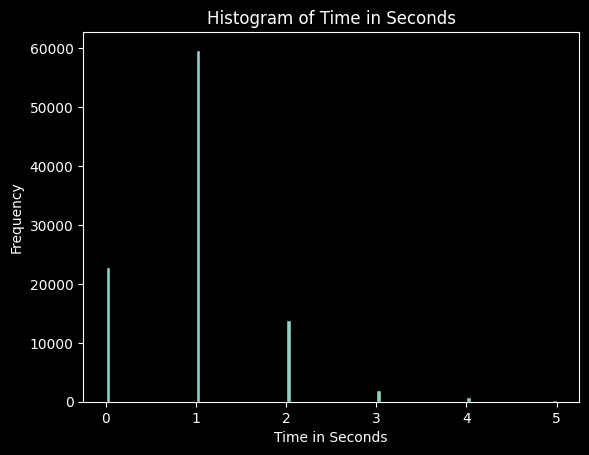

In [25]:
timeFrame = calculateDeltaTime(df, 'responseTime', 'requestTime')
plt.hist(timeFrame[timeFrame['secondsDifference']<6]['secondsDifference'], bins = 100, edgecolor = 'black')
plt.xlabel('Time in Seconds')
plt.ylabel('Frequency')
plt.title('Histogram of Time in Seconds')
plt.show()

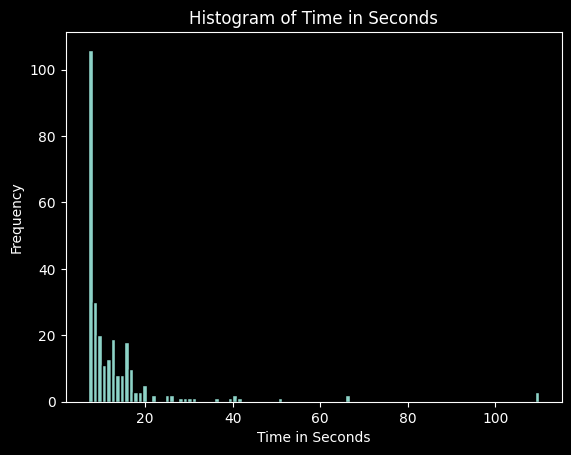

In [26]:
plt.hist(timeFrame[timeFrame['secondsDifference']>6]['secondsDifference'], bins = 100, edgecolor = 'black')
plt.xlabel('Time in Seconds')
plt.ylabel('Frequency')
plt.title('Histogram of Time in Seconds')
plt.show()

In [27]:
timeFrame.describe().style.apply(highlight_odd_rows)

,secondsDifference
count,100000.000000
mean,1.026080
std,1.210436
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,110.000000


In [28]:
timeFrame[timeFrame['secondsDifference'] <= 6].describe().style.apply(highlight_odd_rows)

,secondsDifference
count,99725.000000
mean,0.992339
std,0.773818
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,6.000000


In [29]:
timeFrame[timeFrame['secondsDifference'] > 6].describe().style.apply(highlight_odd_rows)

,secondsDifference
count,275.000000
mean,13.261818
std,12.888510
min,7.000000
25%,7.500000
50%,10.000000
75%,14.000000
max,110.000000


In [30]:
timeFrame.max().values.tolist()

[110.0]

<h3>A continuación se comprueba que cada diccionario del valor de la columna carfaxUsaData con una llave "error" le corresponda un valor distinto a lista vacía</h3>

In [31]:
def proveErrorAlert(df):
    '''
    Assures every error in CarfaxUsaData is associated with an alert
    Args:
       df (DataFrame) : Dataframe which contains the columns to substraction
    Returns:
       ... (string): Returns a status message
    '''
    carfaxUsaData = df['carfaxUsaData'].values.tolist()
    conError = 0
    for index1 in range(len(carfaxUsaData)):
        carfaxDict = json.loads(carfaxUsaData[index1])
        if 'error' in list(carfaxDict.keys()):
            conError += 1
            if df.iloc[index1]['alertas'] == []:
                return 'Existe un valor con error y sin alerta'
    return 'Funciona correctamente'

In [32]:
proveErrorAlert(df)

'Funciona correctamente'

<h3>Ahora se estudiará la relación con los Vin's repetidos y las alertas</h3>

In [33]:
def getRepeatedValuesInAColumn(df, columnName):
    '''
    Identifies the repeated values of a column in a dataframe
    Args:
       df (DataFrame) : Dataframe which contains the columns to search
       columnName (string) : Column's name to search
    Returns:
       duplicates['VIN'] (pandas Series): Returns a column as a pandas series of the duplicated values of the columnName
    '''
    duplicates = df[df.duplicated(subset=[columnName], keep=False)]
    return duplicates['VIN']

In [34]:
def searchValuesInADataframe(df, values:list, columnA: str, columnB: str)-> dict:
    '''
    Searches the values of a list in a dataframe columnA and retrieves the information of columnB
    Args:
       values (list): The list of values to be searched
       columnA (string): The name's column to search
       columnB (string): The name's column to retrieve values
       df (DataFrame): The dataframe where where will be searched
    Returns:
      valuesBDict (dict): A dictionary of values as key and the retrieved values of columnB as values
    '''
    
    valuesBDict ={}
    for value in values:
        valuesB = df.loc[df[columnA]== value, columnB].tolist()
        valuesBDict[value] = valuesB
    return valuesBDict

In [35]:
repeatedValues = searchValuesInADataframe(df, getRepeatedValuesInAColumn(df, 'VIN').unique().tolist(), 'VIN', 'alertas')

In [54]:
repeatedValues['3N1AB7AD3JL673266']

['[{"codigo":4,"mensaje":"El dígito verificador en la 9° posición del VIN 3N1AB7AD3JL673266 NO es correcto."}]',
 '[{"codigo":4,"mensaje":"El dígito verificador en la 9° posición del VIN 3N1AB7AD3JL673266 NO es correcto."}]',
 '[{"codigo":4,"mensaje":"El dígito verificador en la 9° posición del VIN 3N1AB7AD3JL673266 NO es correcto."}]',
 '[{"codigo":4,"mensaje":"El dígito verificador en la 9° posición del VIN 3N1AB7AD3JL673266 NO es correcto."}]',
 '[{"codigo":4,"mensaje":"El dígito verificador en la 9° posición del VIN 3N1AB7AD3JL673266 NO es correcto."}]',
 '[{"codigo":4,"mensaje":"El dígito verificador en la 9° posición del VIN 3N1AB7AD3JL673266 NO es correcto."}]',
 '[{"codigo":4,"mensaje":"El dígito verificador en la 9° posición del VIN 3N1AB7AD3JL673266 NO es correcto."}]',
 '[{"codigo":4,"mensaje":"El dígito verificador en la 9° posición del VIN 3N1AB7AD3JL673266 NO es correcto."}]',
 '[{"codigo":4,"mensaje":"El dígito verificador en la 9° posición del VIN 3N1AB7AD3JL673266 NO e

<h4>Identificamos si existe algún VIN repetido que contenga y a la vez no, mensajes de alerta. Además se identifica la cantidad de veces que se repiten los VIN's que lanzan alerta contra los que no lanzan ninguna alerta</h4>

In [37]:
def getIncorrectRepeatedVinInformation(df)->dict:
    '''
    Searches the values of a list in a dataframe columnA and retrieves the information of columnB
    Args:
       df (DataFrame): The dataframe where where will be searched
    Returns:
      ... (dict): A dictionary which contains a status message, a list of good and bad VINs withits appeareance count, and the total count of good and bad VINS
    '''
    vinValues = getRepeatedValuesInAColumn(df, 'VIN').unique().tolist()
    repeatedValues = searchValuesInADataframe(df, vinValues, 'VIN', 'alertas')
    goodVins = 0
    badVins = 0
    goodVinsList = []
    badVinsList = []
    messages = []
    for repeatedVin in list(repeatedValues.keys()):
        differentValuesByVin = list(set(repeatedValues[repeatedVin]))
        for differentValue in differentValuesByVin:
            if differentValue == '[]':
                goodVins += 1
                if len(differentValuesByVin)>1:
                    messages.append(''.join(['Alerta con vin: ',repeatedVin, ' , tiene y no tiene alertas.']))
                else:
                    goodVinsList.append([repeatedVin, len(repeatedValues[repeatedVin])])
            else:
                badVins += 1
                badVinsList.append([repeatedVin, len(repeatedValues[repeatedVin])])
            
    messages.append(''.join(['VINs repetidos que no lanzan alerta: ', str(goodVins), '\nVINs repetidos que sí lanzan alerta: ', str(badVins)]))
    return {'message': messages,
           'goodVinsList': goodVinsList,
           'badVinsList': badVinsList,
           'goodVins':goodVins,
           'badVins': badVins}

In [38]:
incorrectInformation = getIncorrectRepeatedVinInformation(df)

In [39]:
incorrectInformation['message']

['Alerta con vin: 1FMC%C3%9A0H91DUB95282 , tiene y no tiene alertas.',
 'Alerta con vin: 5XYKT4A61CG229893 , tiene y no tiene alertas.',
 'Alerta con vin: 1FADP3F23FL269002 , tiene y no tiene alertas.',
 'Alerta con vin: 1C4PJLLB0JD511938 , tiene y no tiene alertas.',
 'Alerta con vin: 3N1AB7AD3JL673266 , tiene y no tiene alertas.',
 'Alerta con vin: 3N1CN7AP7JK398484 , tiene y no tiene alertas.',
 'Alerta con vin: 1FTEW1EP8GKE34004 , tiene y no tiene alertas.',
 'Alerta con vin: 1N6SD11Y6VC416953 , tiene y no tiene alertas.',
 'Alerta con vin: 1FTNW20FX2EB73728 , tiene y no tiene alertas.',
 'Alerta con vin: 1FMEU64877UB13472 , tiene y no tiene alertas.',
 'Alerta con vin: 3KPFK4A78HE136256 , tiene y no tiene alertas.',
 'Alerta con vin: 1FT8W4DTXBEB99819 , tiene y no tiene alertas.',
 'Alerta con vin: 1GCCS148558220255 , tiene y no tiene alertas.',
 'Alerta con vin: KNDJP3A59G7350563 , tiene y no tiene alertas.',
 'Alerta con vin: 2C3CDXGJ0HH644067 , tiene y no tiene alertas.',
 'Ale

In [40]:
def diagnoseVins(df, incorrectInformation):
    '''
    Converts the lists of  getIncorrectRepeatedVinInformation() function in dataframes
    Args:
       df (DataFrame): The dataframe where where will be searched
    Returns:
      ... (dict): A dictionary which contains the good and bad VINs dataframes and the good and bad repeated Records of the VINs
    '''
    goodVinsFrame = pd.DataFrame(incorrectInformation['goodVinsList'], columns = ['VIN', 'repeatedTimes'])
    goodRepeatedRecords = goodVinsFrame.sum()['repeatedTimes']
    badVinsFrame = pd.DataFrame(incorrectInformation['badVinsList'], columns = ['VIN', 'repeatedTimes'])
    badRepeatedRecords = badVinsFrame.sum()['repeatedTimes']

    return {'goodVinsFrame': goodVinsFrame, 'badVinsFrame': badVinsFrame, 'goodRepeatedRecords': goodRepeatedRecords, 'badRepeatedRecords': badRepeatedRecords}

In [41]:
diagnosedVins = diagnoseVins(df, incorrectInformation)

In [42]:
diagnosedVins['goodVinsFrame'].describe().style.apply(highlight_odd_rows)

,repeatedTimes
count,13870.000000
mean,4.526172
std,6.632728
min,2.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,189.000000


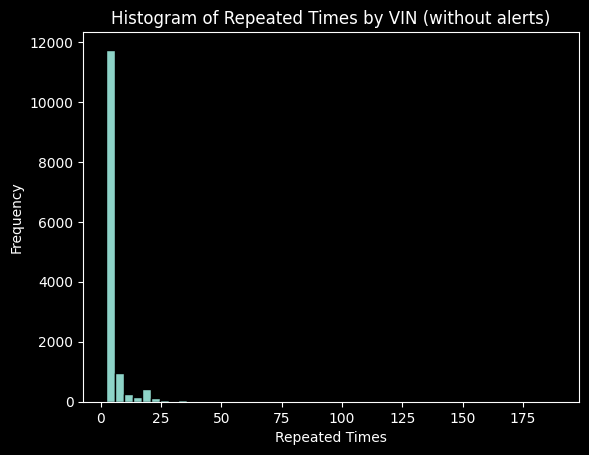

In [43]:
plt.hist(diagnosedVins['goodVinsFrame']['repeatedTimes'], bins = 50, edgecolor = 'black')
plt.xlabel('Repeated Times')
plt.ylabel('Frequency')
plt.title('Histogram of Repeated Times by VIN (without alerts)')
plt.show()

In [44]:
diagnosedVins['badVinsFrame'].describe().style.apply(highlight_odd_rows)

,repeatedTimes
count,2106.000000
mean,4.432099
std,5.761647
min,2.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,81.000000


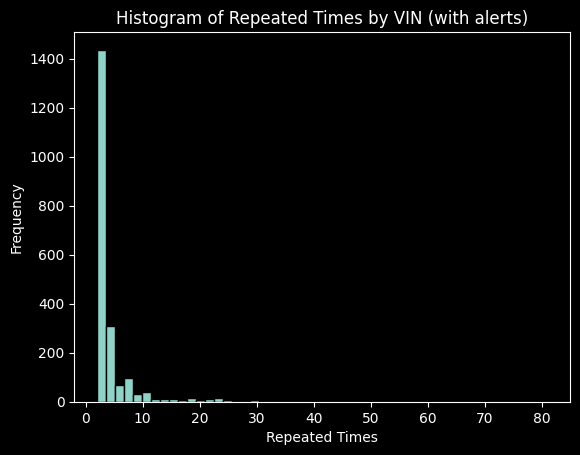

In [45]:
plt.hist(diagnosedVins['badVinsFrame']['repeatedTimes'], bins = 50, edgecolor = 'black')
plt.xlabel('Repeated Times')
plt.ylabel('Frequency')
plt.title('Histogram of Repeated Times by VIN (with alerts)')
plt.show()

<h4>Finalmente tenemos los VINs revisados en todos los registros. La proporción entre VINs repetidos con alerta, VINs repetidos sin alerta. Máximos y mínimos repeticiones</h4>

Cantidad de registros repetidos:  72112
Cantidad de registros repetidos con VINs sin alerta:  62778
Cantidad de registros repetidos con VINs con alerta:  9334
Cantidad de VINs revisados en esos registros repetidos:  15976


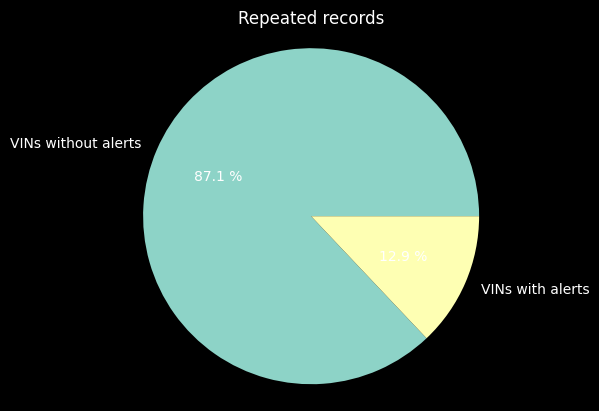

In [46]:
print('Cantidad de registros repetidos: ', diagnosedVins['goodRepeatedRecords'] + diagnosedVins['badRepeatedRecords'])
print('Cantidad de registros repetidos con VINs sin alerta: ', diagnosedVins['goodRepeatedRecords'])
print('Cantidad de registros repetidos con VINs con alerta: ', diagnosedVins['badRepeatedRecords'])
print('Cantidad de VINs revisados en esos registros repetidos: ', list(diagnosedVins['badVinsFrame'].count() + diagnosedVins['goodVinsFrame'].count())[1])
repetitionProportion = [diagnosedVins['goodRepeatedRecords'], diagnosedVins['badRepeatedRecords']]
labelsRepetition = ['VINs without alerts', 'VINs with alerts']
plt.pie(repetitionProportion, labels=labelsRepetition, autopct="%0.1f %%")
plt.axis("equal")
plt.title('Repeated records')
plt.show()

<h4>Estadísticas de las repeticiones de los VINs sin alerta</h4>

In [47]:
diagnosedVins['goodVinsFrame'].describe().style.apply(highlight_odd_rows)

,repeatedTimes
count,13870.000000
mean,4.526172
std,6.632728
min,2.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,189.000000


<h4>Estadísticas de las repeticiones de los VINs con alerta</h4>

In [48]:
diagnosedVins['badVinsFrame'].describe().style.apply(highlight_odd_rows)

,repeatedTimes
count,2106.000000
mean,4.432099
std,5.761647
min,2.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,81.000000


<h3>Ahora se comprueba que para cada VIN repetido se dió exactamente la misma información, y en caso de tener alerta, también se dieron las mismas alertas</h3>

In [55]:
def verifyInfoRepeatedVins(df):
    '''
    Verifies every repeated VIN has the same information in every record (due to the short period time reviewed)
    Args:
       df (DataFrame): The dataframe where where will be searched
    Returns:
      ... (dict): A dictionary which contains the different responses as a dict for every repeated VIN in uniqueResponses and VINs with more than one response in differentResponse key
    '''
    uniqueResponses = {}
    differentResponses = {}
    vinValues = getRepeatedValuesInAColumn(df, 'VIN').unique().tolist()
    repeatedValues = searchValuesInADataframe(df, vinValues, 'VIN', 'responseBody')
    repeatedVins = repeatedValues.keys()
    for vin in repeatedVins:
        uniqueResponses[vin] = []
        listJson = []
        for responseString in repeatedValues[vin]:
            responseJson = json.loads(responseString)
            listJson.append(responseJson)
        repeatedValues[vin] = listJson
    for vin in repeatedVins:
        for responseJson in repeatedValues[vin]:
            keys = list(responseJson.keys())
            if 'fabricante' in keys and 'paisOrigen' in keys:
                info = {'anioModelo': responseJson['anioModelo'], 'fabricante': responseJson['fabricante'], 'marca': responseJson['marca'], 'modelo': responseJson['modelo'], 'paisOrigen': responseJson['paisOrigen'], 'robo': responseJson['robo'], 'roboFecha': responseJson['roboFecha'], 'codes': []}
            else:
                 info = {'anioModelo': responseJson['anioModelo'], 'marca': responseJson['marca'], 'modelo': responseJson['modelo'], 'robo': responseJson['robo'], 'roboFecha': responseJson['roboFecha'], 'codes': []}
            if  responseJson['mensajes'] != []:
                for message in responseJson['mensajes']:
                    info['codes'].append(message['codigo'])
                    info['codes'] = list(set(info['codes']))
                if len(info['codes'])>1:
                    info['codes'] = info['codes'].sort()
            if uniqueResponses[vin] == []:
                 uniqueResponses[vin].append(info)
            else:
                if info not in uniqueResponses[vin]:
                    uniqueResponses[vin].append(info)
                    #info['tiempoRespuesta'] = responseJson['tiempoRespuesta']
                    differentResponses[vin] = info
    return {'uniqueResponses': uniqueResponses, 'differentResponses': differentResponses}

In [56]:
verifyResponses = verifyInfoRepeatedVins(df)
if verifyResponses['differentResponses'] != {}:
    print('Existen respuestas distintas para un mismo VIN')

Existen respuestas distintas para un mismo VIN


In [57]:
differentResponseVins = list(verifyResponses['differentResponses'].keys())

In [58]:
print(differentResponseVins)

['1FMCU0H91DUB95282', '1FMC%C3%9A0H91DUB95282', '5XYKT4A61CG229893', '1FADP3F23FL269002', '1C4PJLLB0JD511938', '3N1AB7AD3JL673266', '3N1CN7AP7JK398484', '1FTEW1EP8GKE34004', '1N6SD11Y6VC416953', '1FTNW20FX2EB73728', '1GCEK19T93E356330', '1FMEU64877UB13472', '3KPFK4A78HE136256', '1FT8W4DTXBEB99819', '1HTLDTVN0GHA63947', '1GCCS148558220255', 'KNDJP3A59G7350563', '2C3CDXGJ0HH644067', '1GKDT13S342421706', '1D8GT28K27W610546', '3FAHP0JA8AR340851', '1FM5K7F85GGA08596', '1GKEC13Z94R246192', '3GTU2NEC7JG416507', '1FTMF1CM6DFA29817', 'KM8J23A47HU260512', 'KM8J33A4XHU461611', '2A4RR4DE1AR315031', '5NPE24AF0HH520224', '1FMCU02Z28KA03653', '1C4PJLCB0EW163391', '1G1ZD5EU0BF250268', '3N1CB51D01L425456', '1N4BL11D55C152181']


In [59]:
for response in differentResponseVins:
    print('VIN', response)
    for information in verifyResponses['uniqueResponses'][response]:
        print(information)
    print('------------')

VIN 1FMCU0H91DUB95282
{'anioModelo': '2013', 'fabricante': 'FORD MOTOR COMPANY', 'marca': 'FORD', 'modelo': 'ESCAPE SEL', 'paisOrigen': 'ESTADOS UNIDOS (USA)', 'robo': False, 'roboFecha': None, 'codes': []}
{'anioModelo': '2013', 'marca': 'FORD', 'modelo': 'ESCAPE SEL', 'robo': False, 'roboFecha': None, 'codes': []}
------------
VIN 1FMC%C3%9A0H91DUB95282
{'anioModelo': '2013', 'fabricante': 'FORD MOTOR COMPANY', 'marca': 'FORD', 'modelo': None, 'paisOrigen': 'ESTADOS UNIDOS (USA)', 'robo': False, 'roboFecha': None, 'codes': [4]}
{'anioModelo': None, 'marca': None, 'modelo': None, 'robo': False, 'roboFecha': None, 'codes': []}
------------
VIN 5XYKT4A61CG229893
{'anioModelo': '2012', 'fabricante': 'KIA GEORGIA, INC', 'marca': 'KIA', 'modelo': 'SORENTO LX', 'paisOrigen': 'ESTADOS UNIDOS (USA)', 'robo': False, 'roboFecha': None, 'codes': []}
{'anioModelo': '2012', 'fabricante': 'KIA GEORGIA, INC', 'marca': 'KIA', 'modelo': 'SORENTO LX', 'paisOrigen': 'ESTADOS UNIDOS (USA)', 'robo': True,

In [68]:
df[df['firewallUsa']==1].style.apply(highlight_odd_rows)